<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-del-projecto-equipo-106/blob/main/Reto_entrega1_Equipo106.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

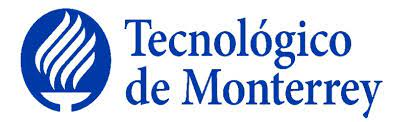

###Maestria: Inteligencia artificial aplicada (MNA)
###Materia:Ciencia y Analítica de Datos 
###Equipo: 106
###->   A01793036 - Julian Gongora
###->   A01793052 - Juan C. Lopez
### Profesor Titular:PhD. María de la Paz Rico Fdz.
### Profesor Tutor: Victoria Guerrero Orozco
### Reto-> Entrega 1 -> Limpieza, análisis, visualización y kmeans

#Proyecto Parte 1 --> Limpieza, análisis, visualización y agrupamiento.

-Explorar  cada datos (auxiliate de describe(), mean(), plot, boxplot de pandas):

* Identificando tendencias centrales promedio, media y mediana de los datos. 
* Identificar medidas de dispersión, máximo, mínimo .
* Identificar medidas de posición no centrales , los cuartiles , outliers.   
* Identificar correlaciones.
* Preparar los datos 

-Realizar análisis para encontrar si existe una relación entre la calidad del agua y su ubicación geográfica a través de K- means.

-Mostrar resultados de agrupamiento de latitudes y longitudes con K means en el mapa de México.

## Librerias para instalar

In [1]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes # Instalacion de librerias Geopandas, xgboost, gensim ,folium, pyLDAvis y descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Librerias a usar.

In [2]:
#Liberia de pandas y numpy para operaciones de data frames y arreglo
import pandas as pd
import numpy as np
#Librerias para hacer plots
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd
from shapely.geometry import Point
#Librerias para leer el archivo en Zip
import os
import requests, zipfile #Librerira para zip de nuestros origen de datos
from io import BytesIO
#---------Librerias de Sklearn ---------------
#libreria para crear pipelines
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
#librerias de Sklearn para procesamiento de datos
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
#Liberias para modelos de aprendizaje
from sklearn.cluster import KMeans #liberia para modelo Kmeans

## Lectura de Datos.

**Comentarios:**
* El equipo 106 decidio usar la base de datos de aguas subterraneas.

In [3]:
#Lectura del archivo desde internet para aguas Subterraneas.
url = 'http://201.116.60.46/Datos_de_calidad_del_agua_de_5000_sitios_de_monitoreo.zip'
req = requests.get(url)
zipfile.ZipFile(BytesIO(req.content)).extractall('unzipped_zip/')
df=pd.read_csv('unzipped_zip/Datos_de_calidad_del_agua_2020/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv', encoding = 'latin1')
df.head()
df_sub=df.copy()

## Limpieza de base de datos.

### 1) Revisaremos el Data Frame para ver con que tipo de variables tenemos y cuantos datos tenemos en cada una

In [4]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLAVE                 1068 non-null   object 
 1   SITIO                 1068 non-null   object 
 2   ORGANISMO_DE_CUENCA   1068 non-null   object 
 3   ESTADO                1068 non-null   object 
 4   MUNICIPIO             1068 non-null   object 
 5   ACUIFERO              1068 non-null   object 
 6   SUBTIPO               1068 non-null   object 
 7   LONGITUD              1068 non-null   float64
 8   LATITUD               1068 non-null   float64
 9   PERIODO               1068 non-null   int64  
 10  ALC_mg/L              1064 non-null   float64
 11  CALIDAD_ALC           1064 non-null   object 
 12  CONDUCT_mS/cm         1062 non-null   float64
 13  CALIDAD_CONDUC        1062 non-null   object 
 14  SDT_mg/L              0 non-null      float64
 15  SDT_M_mg/L           

**Comentarios:**
* Se cuenta con 5 variables Flotantes, 1 variable entera, y 51 variables tipo objeto (Tipo categoricas).

**Nota:**
* Existen variables numéricas que el data frame muestra como objeto (tipo categóricas que deben ser cambiadas a numéricas para el análisis de datos).

### 2) Separación de variables.

In [5]:
# Comparando los datos observados se ve que las siguientes variables son numericas.
numericas = ['ALC_mg/L','CONDUCT_mS/cm','SDT_mg/L','SDT_M_mg/L','FLUORUROS_mg/L','DUR_mg/L','COLI_FEC_NMP/100_mL',
                      'N_NO3_mg/L','AS_TOT_mg/L','CD_TOT_mg/L','CR_TOT_mg/L','HG_TOT_mg/L','PB_TOT_mg/L','MN_TOT_mg/L','FE_TOT_mg/L']
# Variables que son coordenadas con las que se trabajara para Kmeans
coordenadas=['LONGITUD','LATITUD']

## Existen dos tipos de categoricas que muestran la informacion unas que muestran si cumple con los estandares de residuos quimicos y otras que muestran el resultado para fines del analisis usaremos las que vienen con respuesta
## Si
#categoricas=['CALIDAD_ALC','CALIDAD_CONDUC','CALIDAD_SDT_ra','CALIDAD_SDT_salin','CALIDAD_FLUO','CALIDAD_DUR','CALIDAD_COLI_FEC',
#             'CALIDAD_N_NO3', 'CALIDAD_AS','CALIDAD_CD','CALIDAD_CR','CALIDAD_HG','CALIDAD_PB','CALIDAD_MN','CALIDAD_FE',]

categoricas=['CUMPLE_CON_ALC',	'CUMPLE_CON_COND',	'CUMPLE_CON_SDT_ra', 'CUMPLE_CON_SDT_salin',	
             'CUMPLE_CON_FLUO',	'CUMPLE_CON_DUR',	'CUMPLE_CON_CF',	'CUMPLE_CON_NO3',	'CUMPLE_CON_AS',	
             'CUMPLE_CON_CD',	'CUMPLE_CON_CR',	'CUMPLE_CON_HG',	'CUMPLE_CON_PB',	'CUMPLE_CON_MN',	'CUMPLE_CON_FE']

#La salida es el color del semaforo que indica si el agua es recomendada para consumir o no
salida=['SEMAFORO']


# Trabajaremos con las variables numericas primero para la limpieza de datos por lo que crearemos un data frame con las variables numericas para proceder con la limpieza y procesamiento.
df_sub_num=df_sub[numericas]
df_sub_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ALC_mg/L             1064 non-null   float64
 1   CONDUCT_mS/cm        1062 non-null   float64
 2   SDT_mg/L             0 non-null      float64
 3   SDT_M_mg/L           1066 non-null   object 
 4   FLUORUROS_mg/L       1068 non-null   object 
 5   DUR_mg/L             1067 non-null   object 
 6   COLI_FEC_NMP/100_mL  1068 non-null   object 
 7   N_NO3_mg/L           1067 non-null   object 
 8   AS_TOT_mg/L          1068 non-null   object 
 9   CD_TOT_mg/L          1068 non-null   object 
 10  CR_TOT_mg/L          1068 non-null   object 
 11  HG_TOT_mg/L          1068 non-null   object 
 12  PB_TOT_mg/L          1068 non-null   object 
 13  MN_TOT_mg/L          1068 non-null   object 
 14  FE_TOT_mg/L          1068 non-null   object 
dtypes: float64(3), object(12)
memory usage

### 3) Conversión de variables numéricas de tipo objeto a flotante

**Comentarios:**
* Se observo a detalle la base de datos y se identificó que algunos variables numéricas muestran datos con formato menor que < y para poder usar estas variables en el análisis se deben convertir a variables flotantes.

In [6]:
df_num=df_sub_num.copy() #Creamos un nuevo data frame para mostrar la limpieza los datos numericos.

for col in numericas: # Un for que corra en todas las columnas de la lista donde se definieron las numericas
  # Son los caracteres que muestran valores menores se convertiran a valores numericos para poder ser analizados.
  df_num[col]=df_num[col].replace('<25','25')
  df_num[col]=df_num[col].replace('<0.2','0.2')
  df_num[col]=df_num[col].replace('<0.02','0.02')
  df_num[col]=df_num[col].replace('<20','20')
  df_num[col]=df_num[col].replace('<1.1','1.1')
  df_num[col]=df_num[col].replace('<0.01','0.01')
  df_num[col]=df_num[col].replace('<0.003','0.003')
  df_num[col]=df_num[col].replace('<0.005','0.004')
  df_num[col]=df_num[col].replace('<0.0005','0.0005')
  df_num[col]=df_num[col].replace('<0.0015','0.0015')
  df_num[col]=df_num[col].replace('<0.025','0.025')
  # Una vez que la columna paso por cada uno de los casos se convierte a flotante si ya no hay caracteres o cadena de ellos.
  df_num[col]=df_num[col].astype('float') 

df_num.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ALC_mg/L             1064 non-null   float64
 1   CONDUCT_mS/cm        1062 non-null   float64
 2   SDT_mg/L             0 non-null      float64
 3   SDT_M_mg/L           1066 non-null   float64
 4   FLUORUROS_mg/L       1068 non-null   float64
 5   DUR_mg/L             1067 non-null   float64
 6   COLI_FEC_NMP/100_mL  1068 non-null   float64
 7   N_NO3_mg/L           1067 non-null   float64
 8   AS_TOT_mg/L          1068 non-null   float64
 9   CD_TOT_mg/L          1068 non-null   float64
 10  CR_TOT_mg/L          1068 non-null   float64
 11  HG_TOT_mg/L          1068 non-null   float64
 12  PB_TOT_mg/L          1068 non-null   float64
 13  MN_TOT_mg/L          1068 non-null   float64
 14  FE_TOT_mg/L          1068 non-null   float64
dtypes: float64(15)
memory usage: 125.3 KB


**Comentarios:**
* No hay valores tipo objeto dentro del data frame "df_num" que es el data frame que usaremos de ahora en adelante para limpiar los datos.

### 4) Eliminacion de columnas vacias.

**Comentario:**

* Observamos en la información de df_num.info() lo siguiente en la siguiente columna: 2 SDT_mg/L 0 non-null float64, significa que esa columna esta vacía no tiene ningún dato posiblemente al capturar los datos no se guardaron o el sensor simplemente se decidió no conectar.
Para fines de este análisis decidiremos eliminar esa columna del data frame df_num




In [7]:
#Eliminacion de la columna STD_mg/L del data frame.
df_num.drop('SDT_mg/L', axis=1, inplace=True)
#debido a que eliminamos una variable que estaba vacia la lista que contiene las columnas numericas se debe actualizar con las columnas de df_num
numericas=df_num.columns

In [8]:
df_num.head()

,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
0,229.990,940.0,603.6,0.9766,213.7320,1.1,4.184656,0.0161,0.003,0.004,0.0005,0.004,0.0015,0.0891
1,231.990,608.0,445.4,0.9298,185.0514,1.1,5.750110,0.0134,0.003,0.004,0.0005,0.004,0.0015,0.0250
2,204.920,532.0,342.0,1.8045,120.7190,1.1,1.449803,0.0370,0.003,0.004,0.0005,0.004,0.0015,0.0250
3,327.000,686.0,478.6,1.1229,199.8790,1.1,1.258597,0.0154,0.003,0.005,0.0005,0.004,0.0015,0.0250
4,309.885,1841.0,1179.0,0.2343,476.9872,291.0,15.672251,0.0100,0.003,0.004,0.0005,0.004,0.0015,0.0250


## Explorar  cada datos (auxiliate de describe(), mean(), plot, boxplot de pandas)

### 1)Explorar  cada datos (auxiliate de describe(), mean(), plot, boxplot de pandas)

#### Identificando tendencias centrales promedio, media y mediana de los datos. 

* Identificando tendencias centrales promedio, media y mediana de los datos. 
* Identificar medidas de dispersión, máximo, mínimo .   

In [9]:
df_num.describe()

,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
count,1064.000000,1062.000000,1066.000000,1068.000000,1067.000000,1068.000000,1067.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000
mean,235.633759,1138.953013,896.101567,1.075600,347.938073,355.490356,4.319759,0.019618,0.003030,0.012476,0.000557,0.004310,0.072478,0.410387
std,116.874291,1245.563674,2751.530590,1.924278,359.669452,2052.457014,8.345134,0.035209,0.000894,0.154435,0.000467,0.003342,0.376512,5.537974
min,26.640000,50.400000,25.000000,0.200000,20.000000,1.100000,0.020000,0.010000,0.003000,0.004000,0.000500,0.004000,0.001500,0.025000
25%,164.000000,501.750000,337.500000,0.267175,121.194800,1.100000,0.650294,0.010000,0.003000,0.004000,0.000500,0.004000,0.001500,0.025000
50%,215.527500,815.000000,550.400000,0.503500,245.335800,1.100000,2.080932,0.010000,0.003000,0.004000,0.000500,0.004000,0.001500,0.046960
75%,292.710000,1322.750000,916.100000,1.139850,453.930000,13.250000,5.201698,0.010000,0.003000,0.004000,0.000500,0.004000,0.009947,0.173380
max,1650.000000,18577.000000,82170.000000,34.803300,3810.692200,24196.000000,121.007813,0.452200,0.032110,5.003200,0.014150,0.080900,8.982000,178.615000


**Comentarios:**

* Se observa que las escalas de max y min son diferentes entre cada variable.
* El promedio es diferente para cada variable.
* La desviación estándar es diferente en cada variable.
* La mediana es el 50% que muestra la tabla también se muestra distinta para cada variable.
* Los cuartiles 25% y 75% son diferentes rangos en la mayoría de las variables.

**Nota:**

Para solucionar este problema se recomienda realizar una transformación para escalar los datos MinMaxScaler y todos estén las mismas escalas de máximo y mínimo.


#### Identificar medidas de posición no centrales , los cuartiles , outliers.   

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 14 Text major ticklabel objects>)

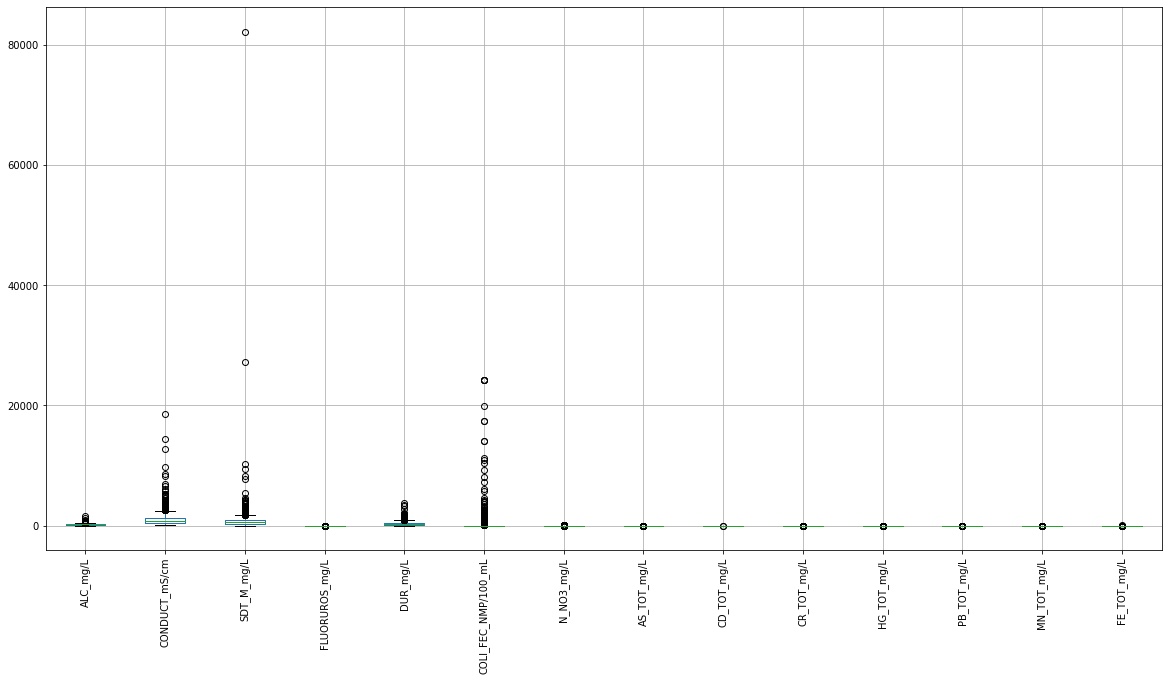

In [10]:
df_num.boxplot(figsize = (20,10))
plt.xticks(rotation=90)

**Comentarios:**

*Se observan muchos outliers en las variables "CONDUCT_mS/cm", "SDT_M_mg/L", "COLI_FEC_NMP/100_mL".
*La mayoría de las variables muestran una alta concentración de datos en el valor mínimo.

#### Identificar correlaciones.

**Comentario:**
* Se creara un mapa de calor para visualizar la correlación entre variables.

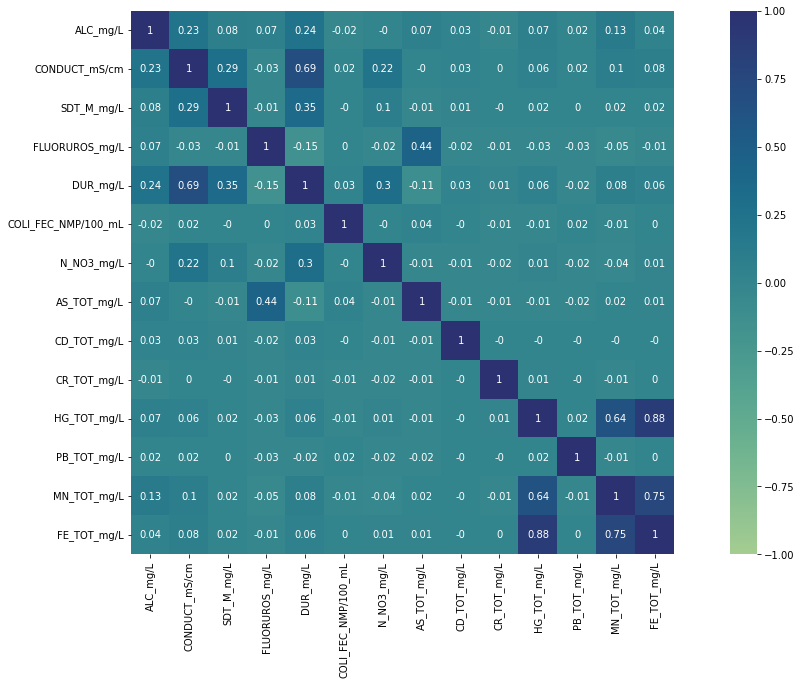

In [11]:
plt.subplots(figsize = (20,10))
sns.heatmap(np.round(df_num.corr(),2),vmax = 1, vmin = -1, square = True, annot = True,cmap="crest") 

**Comentarios:**

De acuerdo con (Vinusa,2016). La correlación es en esencia una medida normalizada de asociación o covariación lineal entre dos variables. Esta medida o índice de correlación r puede variar entre -1 y +1, ambos extremos indicando correlaciones perfectas, negativa y positiva respectivamente. Un valor de r = 0 indica que no existe relación lineal entre las dos variables. Una correlación positiva indica que ambas variables varían en el mismo sentido. Una correlación negativa significa que ambas variables varían en sentidos opuestos. Lo interesante del índice de correlación es que r es en sí mismo una medida del tamaño del efecto, que suele interpretarse de la siguiente manera:

* correlación despreciable: r < |0.1|
* correlación baja: |0.1| < r <= |0.3|
* correlación mediana : |0.3| < r <= |0.5|
* correlación fuerte o alta: r > |0.5|

Observamos que las siguientes variables tiene una fuerte correlación.
* DUR_mg/L vs CONDUCT_mS/cm
* HG_TOT_mg/L vs MN_TOT_mg/L
* HG_TOT_mg/L vs FE_TOT_mg/L
* MN_TOT_mg/L vs FE_TOT_mg/L


#### Preparar los datos 

##### 1) Para la preparacion de datos primero visualizaremos estos y probaremos diferentes transformacion para centrar los datos.

In [12]:
# Se define el tipo de variables a usar la entrada.

def transformaciones(variables_a_transformar, datos_a_transformar):
  sns.set(rc={'figure.figsize':(40,30)})
  k=0
  fig, ax = plt.subplots(5,len(variables_a_transformar))   
  for k in range(0,len(variables_a_transformar)):  
      # Datos originales ---------------------------------------------------------
      #plt.subplot(1,(k+1)) 
      Transf0 = datos_a_transformar[variables_a_transformar[k]]         #  En esta línea se debe asignar a Transf0 los valores de cada variable "k" sin transformar.
      ax[0,k].hist(Transf0, bins=20)                             #  En este línea agrega el comando para obtener el histograma de Transf0 con 20 barras (bins).
      ax[0,k].set(xlabel=variables_a_transformar[k])
      if k==0:
        ax[0,k].set(ylabel='Originales')
    
    
      
      # Datos transformados con raíz cuadrada ------------------------------------
      #plt.subplot(2,(k+1))    

      Transf1 = np.sqrt(Transf0)         #  En esta línea se debe aplicar la raíz cuadrada a los valores de cada variable "k" sin transformar.
      plt.xlabel(variables_a_transformar[k])
      ax[1,k].hist(Transf1, bins=20)         #  En este línea agrega el comando para obtener el histograma de Transf1 con 20 barras (bins).
      ax[1,k].set(xlabel=variables_a_transformar[k])
      if k==0:
        ax[1,k].set(ylabel='Raíz cuadrada')
      

      
      # Datos transformados con logaritmo natural --------------------------------
      #plt.subplot(3,(k+1))     

      Transf2 = np.log(Transf0)         #  En esta línea se debe aplicar el logaritmo natural a los valores de cada variable "k" sin transformar.
      ax[2,k].hist(Transf2, bins=20)        #  En este línea agrega el comando para obtener el histograma de Transf2 con 20 barras (bins).
      ax[2,k].set(xlabel=variables_a_transformar[k])
      if k==0:
        ax[2,k].set( ylabel='logaritmo natural')

      
      


      # Datos transformados con la potencia de 2 ---------------------------------
      #plt.subplot(4,(k+1))

      Transf3 = np.power(Transf0,2)          #  En esta línea debes elevar al cuadrado los valores de cada variable "k" sin transformar.
      ax[3,k].hist(Transf3, bins=20)             #  En este línea agrega el comando para obtener el histograma de Transf3 con 20 barras (bins).
      ax[3,k].set(xlabel=variables_a_transformar[k])
      if k==0:
         ax[3,k].set( ylabel='potencia 2')
      
      

      # Datos transformados con Box-Cox ------------------------------------------
      #plt.subplot(5,(k+1))

      Transf4 = power_transform(np.array(Transf0).reshape(-1, 1), method='box-cox')          #  En esta línea se debe aplicar la transformación Box-Cox a los valores de cada variable "k" sin transformar.
      ax[4,k].hist(Transf4, bins=20)                    #  En este línea agrega el comando para obtener el histograma de Transf4 con 20 barras (bins).
      ax[4,k].set(xlabel=variables_a_transformar[k])
      if k==0:
        ax[4,k].set(ylabel='box-cox')


**Nota:**
Debido a que aun no se eliminan los valores NAN de la funciones ya que se planea hacer con un pipeline realizaremos otra variable solo para visualizar los datos sin los valores NAN.

In [13]:
df_numdrop=df_num.dropna(axis=0) # Se eliminaran todas las filas que tengan datos NAN 

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


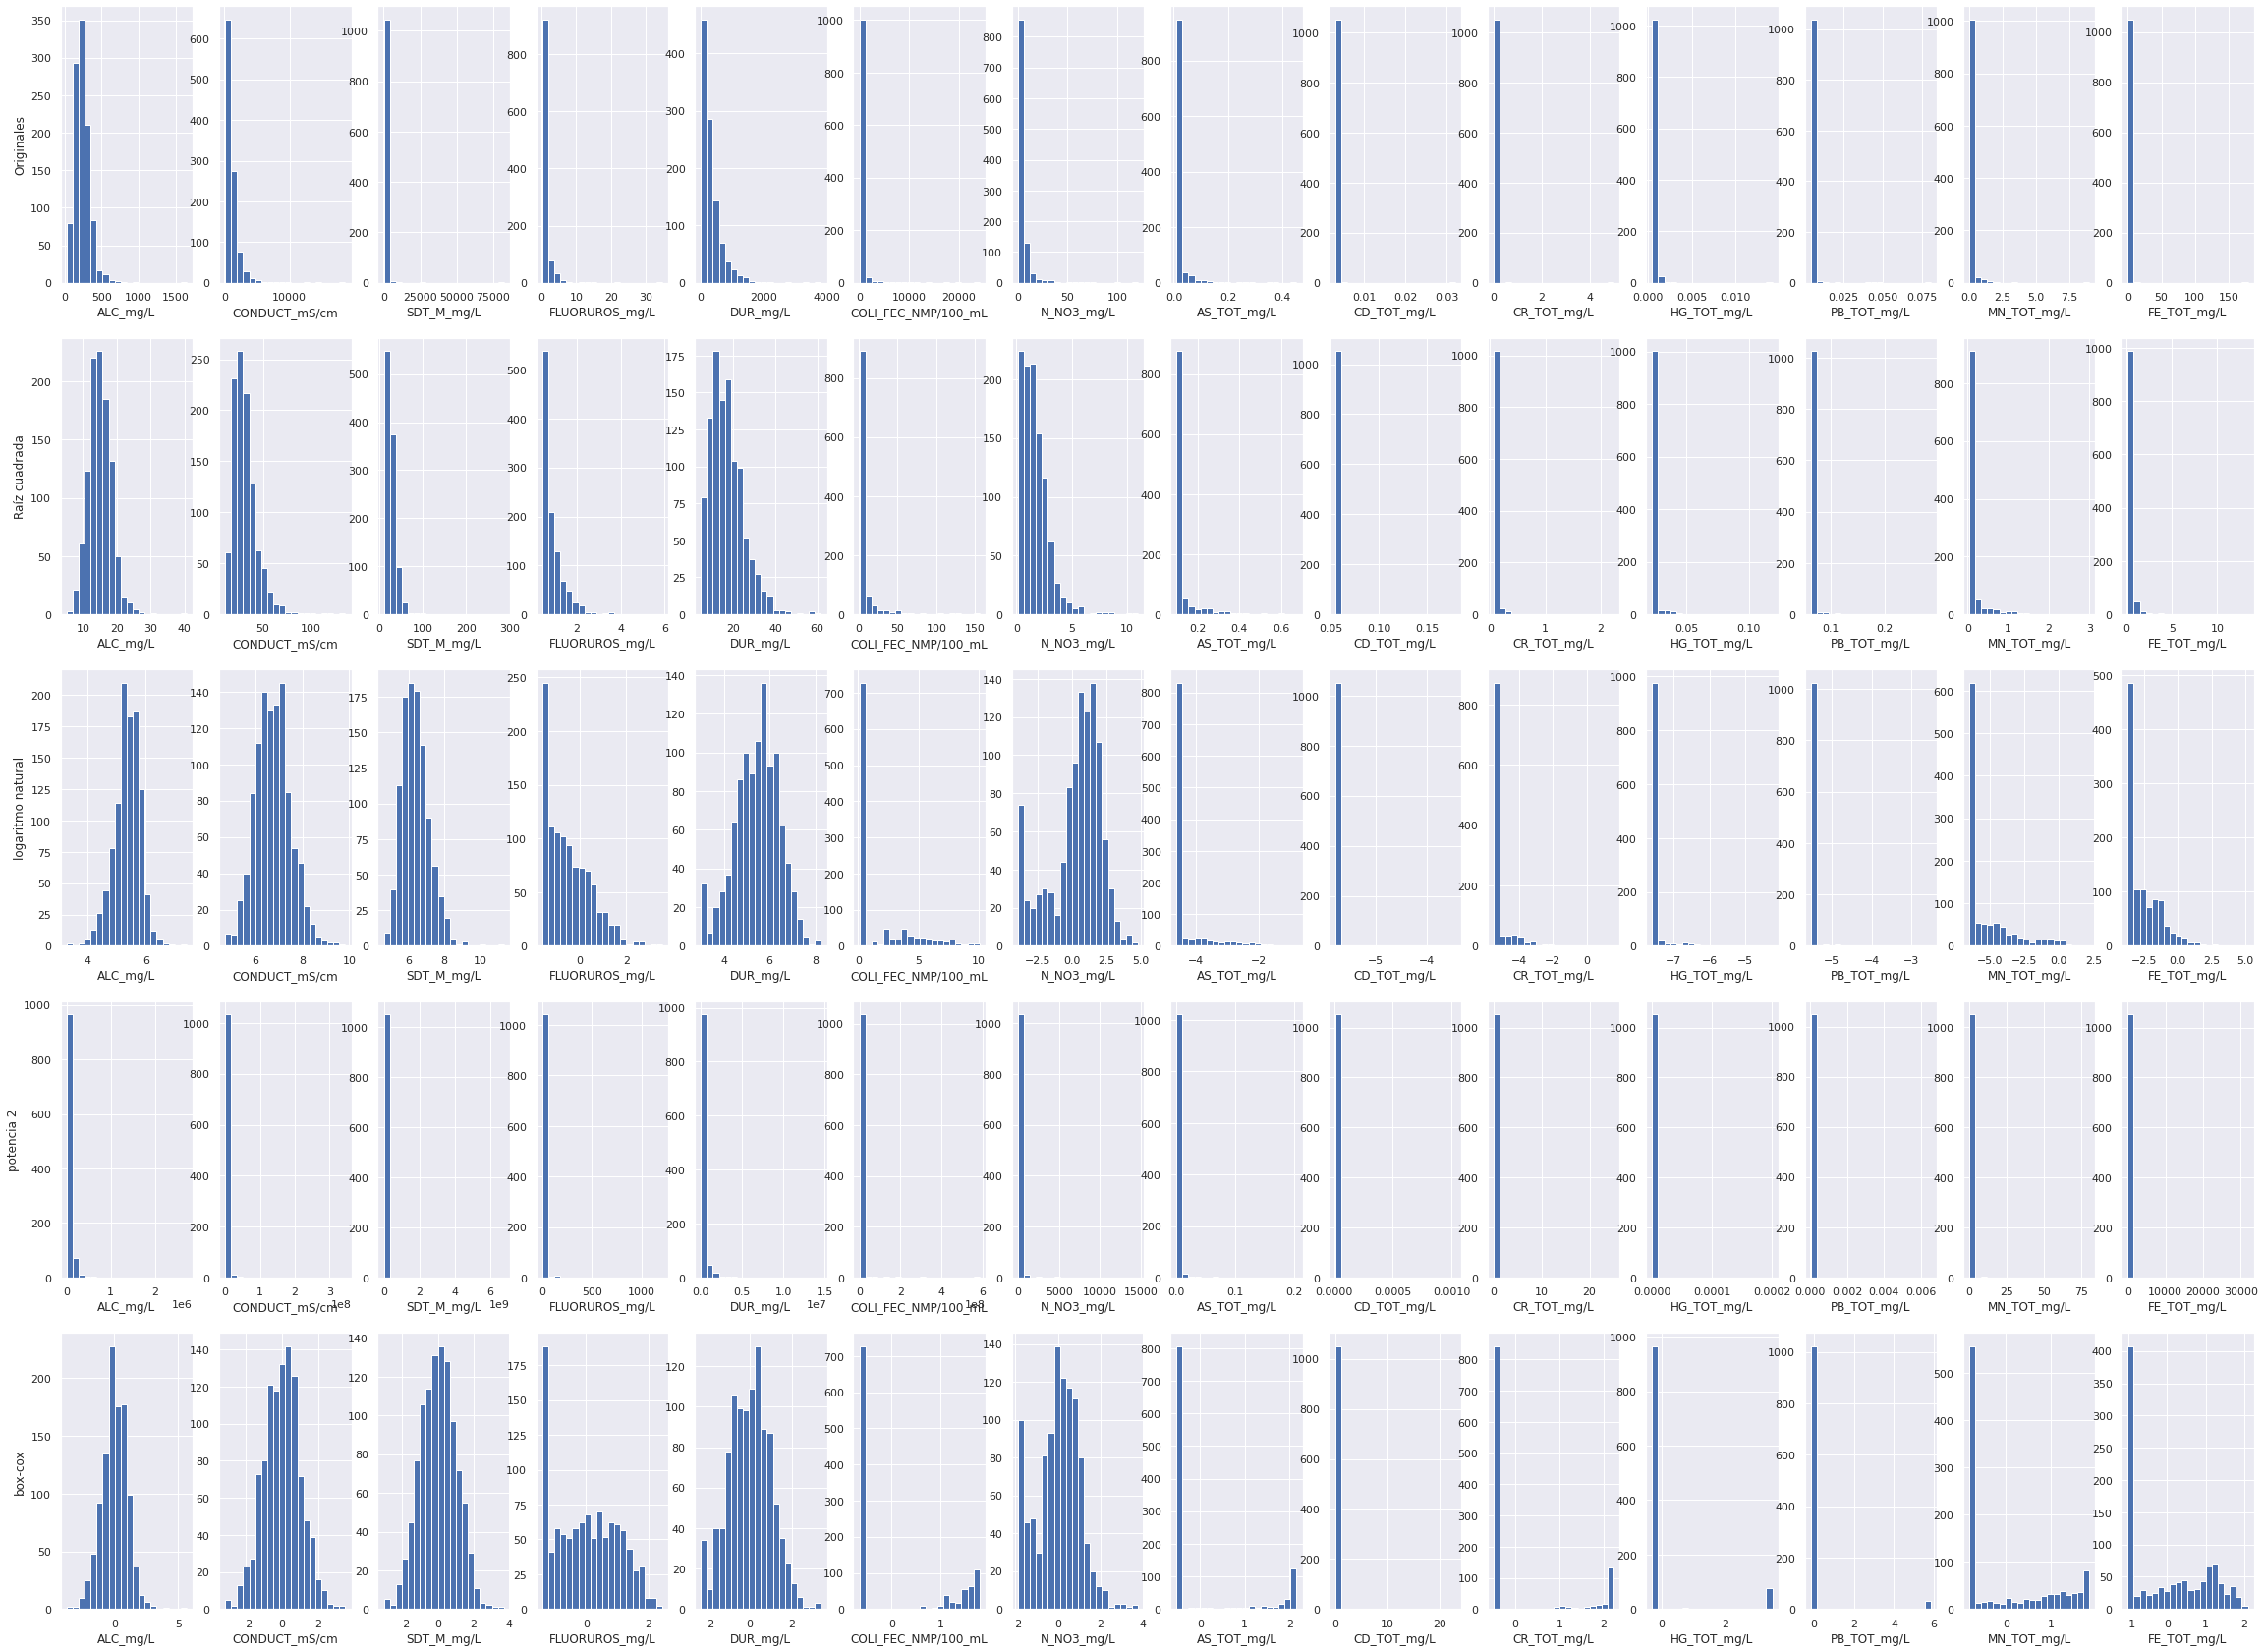

In [14]:
transformaciones(numericas,df_numdrop) #Llamamos la funcion Tranformaciones para probar cada una de ellos en las variables.

**Comentarios:**

Algunas variables tienen datos muy centrados en ciertos valores y no logran tener una distribución normal aun aplicando transformaciones pero la que mostraron mejoría en la mayoría de las variables son box-cox y Logaritmo natural.


#####2) Preparacion final de datos numericos.

* Realizaremos un pipeline que incluya la imputacion, la transformacion de los datos  y su escalamiento de un rango de 0,10 para que todos esten en la misma escala y facilite la convergencia de los modelos de aprendizaje que se vayan a usar.

In [15]:
# Pipeline que incluye la preparacion de los datos
num_pipe = Pipeline([
    ('impMediana', SimpleImputer(strategy='median')), 
    ('ln',FunctionTransformer(np.log)),
    ('escalaNum', MinMaxScaler(feature_range=(0,10)))
    ])   
num_names = numericas



In [16]:
transformer = ColumnTransformer(
    transformers = [
      ('numpipe', num_pipe, num_names)],
    remainder='passthrough'
)

In [17]:
df_num_trans=pd.DataFrame(transformer.fit_transform(df_num)) #Creamos un data frame con las transformaciones para las variables numericas
df_num_trans.columns=numericas
df_num_trans.describe()

,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
count,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000
mean,5.033240,4.755441,3.898842,2.149353,4.633767,1.430123,4.858884,0.727951,0.011829,0.360471,0.164535,0.092269,1.341545,1.204029
std,1.114879,1.264193,0.947289,1.852937,1.838525,2.434815,2.141411,1.720258,0.316351,0.923232,0.708661,0.671616,2.061311,1.429917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.405473,3.901315,3.214853,0.561307,3.433100,0.000000,3.999449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.066930,4.709549,3.818098,1.789570,4.775190,0.000000,5.334065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.710403
75%,5.806404,5.527097,4.446997,3.373297,5.947256,2.452380,6.385816,0.000000,0.000000,0.000000,0.000000,0.000000,2.175164,2.182306
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 14 Text major ticklabel objects>)

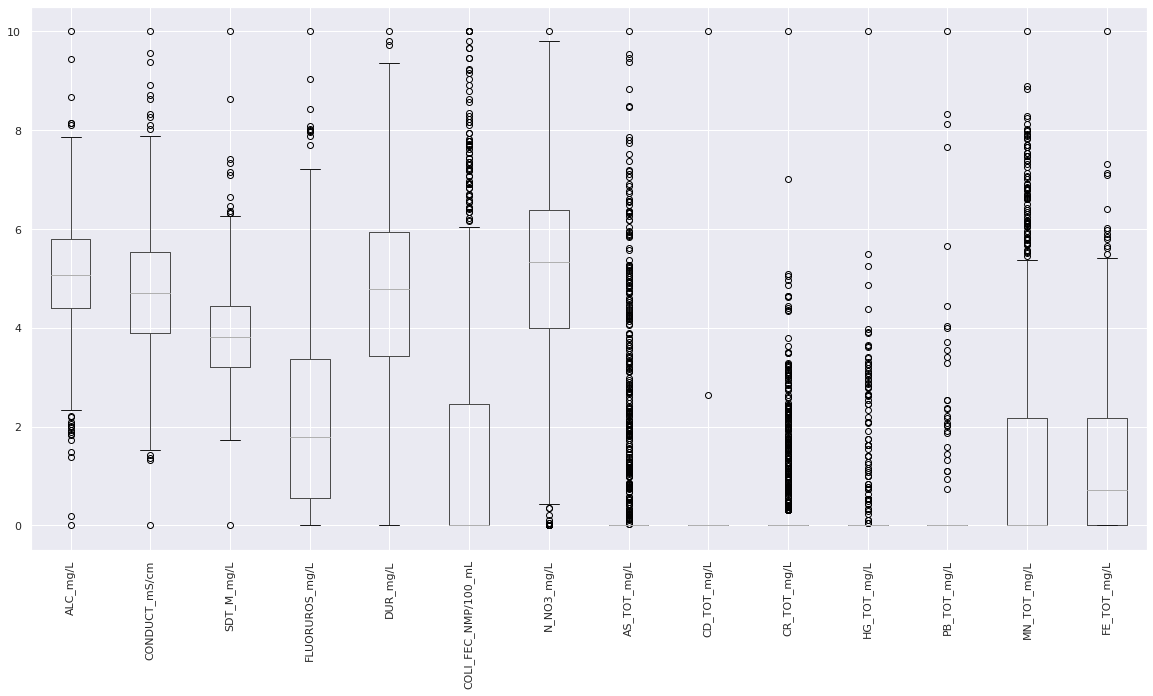

In [18]:
df_num_trans.boxplot(figsize = (20,10))
plt.xticks(rotation=90)

**Comentarios:**
* Se observa una mejora en la distribución de la mayoría de las variables y se alcanzan a percibir los cuartiles así como sus outliers.

In [19]:
# Tomamos la variable de salida del data frame original y la asignamos a la variable Y
y=df[salida]

print("cantidad de datos de variables de entrada:",df_num_trans.shape)
print("cantidad de datos de variable de salida:",y.shape)


cantidad de datos de variables de entrada: (1068, 14)
cantidad de datos de variable de salida: (1068, 1)


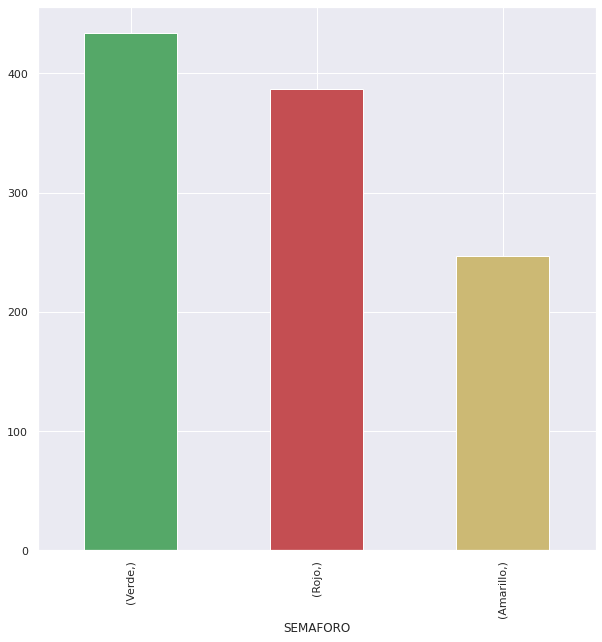

In [20]:
y.value_counts().plot(kind='bar',figsize = (10,10),color=['g','r','y'])

In [21]:
V,R,A=y.value_counts()
print("Cantidad de datos en Verde:%f%%" %(V/len(y)*100))
print("Cantidad de datos en Rojo:%f%%"%(R/len(y)*100))
print("Cantidad de datos en Amarillo:%f%%"%(A/len(y)*100))

Cantidad de datos en Verde:40.636704%
Cantidad de datos en Rojo:36.235955%
Cantidad de datos en Amarillo:23.127341%


**Comentarios:**
* No se encuentran un desbalanceo de datos en la salida ya que se tienen valores mayores al 20% en las clases de la salida donde predominan los valores verdes.

##Realizar análisis para encontrar si existe una relación entre la calidad del agua y su ubicación geográfica a través de K- means.

Para esta parte usaremos las variables de coordenadas y el data Frame de salida "y" para ver si existe una relacion entre la calidad del aguageográfica a través de K- means.

In [22]:
df_coord=df[coordenadas] # creamos un data frame con las variables de coordenadas.

In [23]:
df_coord

,LONGITUD,LATITUD
0,-102.02210,22.20887
1,-102.20075,21.99958
2,-102.28801,22.36685
3,-102.29449,22.18435
4,-110.24480,23.45138
...,...,...
1063,-99.54191,24.76036
1064,-99.70099,24.78280
1065,-99.82249,25.55197
1066,-100.32683,24.80118


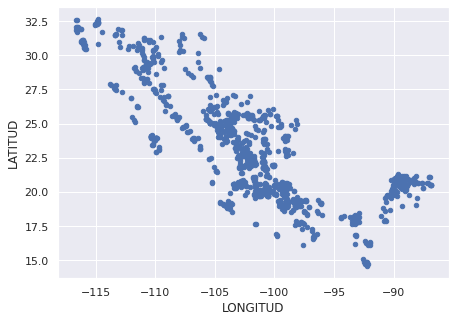

In [24]:
df_coord.plot.scatter("LONGITUD","LATITUD",figsize = (7,5))

**Comentarios:**

Observamos que los coordenadas forman el país de México ya que la base de datos muestra la ubicación de los aguas subterráneas en México .

### 1) Para obtener una mejor visualización de la salida convertiremos los valores de verde, Rojo y amarillo a sus respectivos en inglés para usarlos en el plot.

In [25]:
y_ing=y.copy() #Copiamos el data frame de salida para no afectarlos datos.
y_ing['SEMAPHORE'] = y['SEMAFORO'].replace(to_replace = "Verde", value = "green")
y_ing['SEMAPHORE'].replace(to_replace = "Rojo", value = "red", inplace=True)
y_ing['SEMAPHORE'].replace(to_replace = "Amarillo", value = "yellow", inplace=True)
y_ing

,SEMAFORO,SEMAPHORE
0,Verde,green
1,Verde,green
2,Rojo,red
3,Verde,green
4,Rojo,red
...,...,...
1063,Rojo,red
1064,Rojo,red
1065,Rojo,red
1066,Verde,green


**Comentarios:**
* Creamos un data frame con los colores en ingles para usarlos dentro del scatter plot para visualizar los colores del semaforo de calidad del agua.

###2) Utilizacion de la libreria Geopandas para visualizar mejor los datos en un mapa.

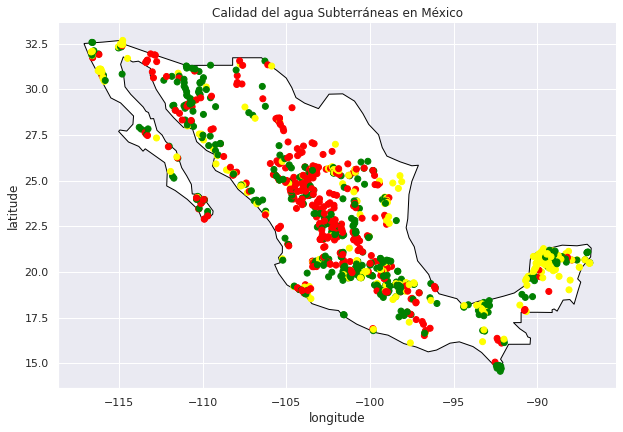

In [26]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'Mexico'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

# Ploteo de aguas subterraneas en por longitud

#df_cor_geo.plot(ax=gax, color=y_ing['SEMAPHORE'], alpha = 1)
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Calidad del agua Subterráneas en México')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
# Ploteo de los datos de las coordernadas considerando el color del semaforo de la calidad del agua
plt.scatter(df_coord["LONGITUD"],df_coord["LATITUD"], c=y_ing['SEMAPHORE'])
plt.show()



**Comentarios:**
*El mapa muestra el país de México como se ve la calidad del agua al rededor del país donde el agua.

>> Puntos Verdes: Calidad Buena del Agua.

>> Puntos Amarillos: Calidad Aceptable.

>> Puntos Rojos: Calidad Mala.



### 3) Definición de numero de Cluster a usar con la gráfica de Codo

In [27]:
clusters=range(1,10) # Se crean del 1 al 20 valores para posibles clusters
inercias=[] # Se crea una lista para las inercias


# Secrea un contador para almacenar las inercias usando diferentes valores de clusters.
for cluster in clusters:
	model = KMeans(n_clusters = cluster) 
	model = model.fit(df_coord)
	
	inercias.append(model.inertia_)


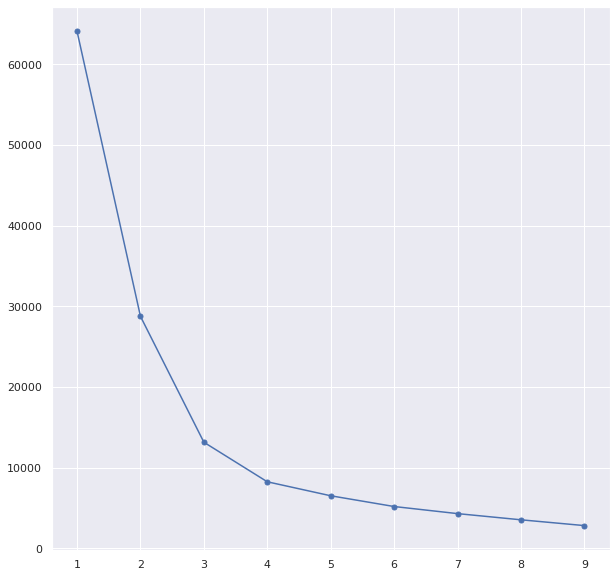

In [28]:
plt.subplots(figsize = (10,10))
plt.plot(clusters, inercias, 'bo-', markersize=5)

**Comentarios:**
* Se tomara el valor de 4 ya que es el valor optimo que se muestra en la grafica de codo ya que la bibliografia comenta Una de las métricas usada para comparar resultados es la distancia media entre los puntos de datos y su centroid. Como el valor de la media diminuirá a medida de aumentemos el valor de K, deberemos utilizar la distancia media al centroide en función de K y entontrar el “punto codo”, donde la tasa de descenso se “afila”

### 4) Entrenamiento de KMeans con el valor optimo.

In [29]:
#Entrenamos el modelo con un valor de 4
model = KMeans(n_clusters = 4)
model.fit(df_coord)


KMeans(n_clusters=4)

In [30]:
centros =model.cluster_centers_
centros= centros[:,0:2] # los dos primeros valores de cada centro son las coordenadas.
centros

array([[-100.23589728,   20.26513862],
       [-111.44537124,   28.7340166 ],
       [ -90.09271578,   19.6502625 ],
       [-103.66798788,   24.78413218]])

**Comentarios:**

* Se encuentran 4 centros con sus respectivas coordenadas.


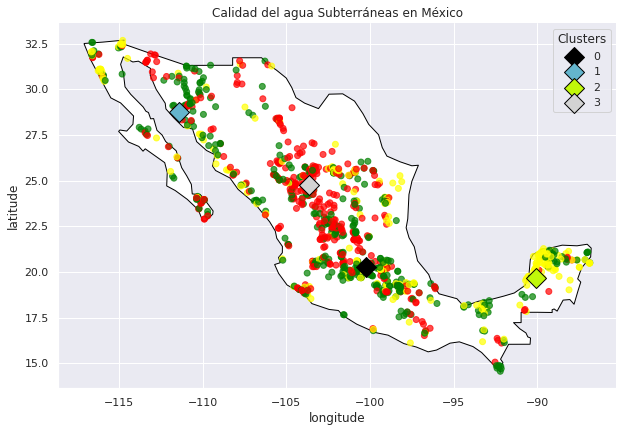

In [31]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'Mexico'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

# Ploteo de aguas subterraneas en por longitud

#df_cor_geo.plot(ax=gax, color=y_ing['SEMAPHORE'], alpha = 1)
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Calidad del agua Subterráneas en México')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
# Ploteo de los datos de las coordernadas considerando el color del semaforo de la calidad del agua
plt.scatter(df_coord["LONGITUD"],df_coord["LATITUD"] ,c=y_ing['SEMAPHORE'],alpha=0.7)

colors = np.array(["black","c","#C1F80A","lightgray"])
for i in range(len(centros)):
	
  plt.scatter(centros[i][0],  centros[i][1],label = i, marker ="D", c=colors[i],
            edgecolor ="black", s = 200)
  plt.legend(title="Clusters",loc = 0)

plt.show()



**Comentarios:**
* Los cuatro centroides o clusters se encuentran ubicados dentro del mapa con la ubicación de cada agua subterránea en México.

In [32]:
##Agregamos nuevas columnas a un data frame que seran las encargadas de tener los coordenadas y para cada centroide
y_centros=y.copy()
centros_df=pd.DataFrame(centros, columns=['centroide latitude','centroide longitude'])
labels=pd.DataFrame(model.labels_, columns=['centroide_cat'])
labels["centroide latitude"]=""
labels["centroide longitude"]=""
for i in range(0,len(labels)):
  for j in range (0,len(centros_df)):
    if labels.iloc[i,0]==j:
      labels.iloc[i,1]=centros_df.iloc[j,0]
      labels.iloc[i,2]=centros_df.iloc[j,1]
y_centros=pd.concat([y_centros,labels],axis=1)

**Comentarios:**

* Procedemos a crear un data frame que incluya los datos del semaforo y los datos de cada categoria de los centroides o clusters con sus coordenadas.

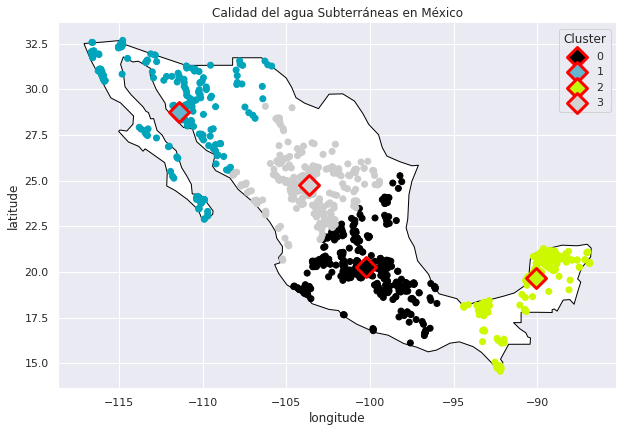

In [33]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'Mexico'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

# Ploteo de aguas subterraneas en por longitud

#df_cor_geo.plot(ax=gax, color=y_ing['SEMAPHORE'], alpha = 1)
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Calidad del agua Subterráneas en México')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

# Ploteo de los datos de las coordernadas considerando el color de cada Cluster de la calidad del agua

plt.scatter(df_coord["LONGITUD"],df_coord["LATITUD"] , c=y_centros['centroide_cat'],cmap='nipy_spectral')

colors = np.array(["black","c","#C1F80A","lightgray"]) # Colores usados en la plantilla

for i in range(len(centros)):
	
  plt.scatter(centros[i][0],  centros[i][1],label = i, marker ="D",
            edgecolor ="red",linewidths=3, s = 200, c=colors[i])
  plt.legend(title="Cluster",loc = 0)


plt.show()


**Comentario:**

* Se observa como las coordenadas de agua subterránea en México fue agrupada por cada centroide o clúster resultado de la agrupación de K-MEAN.

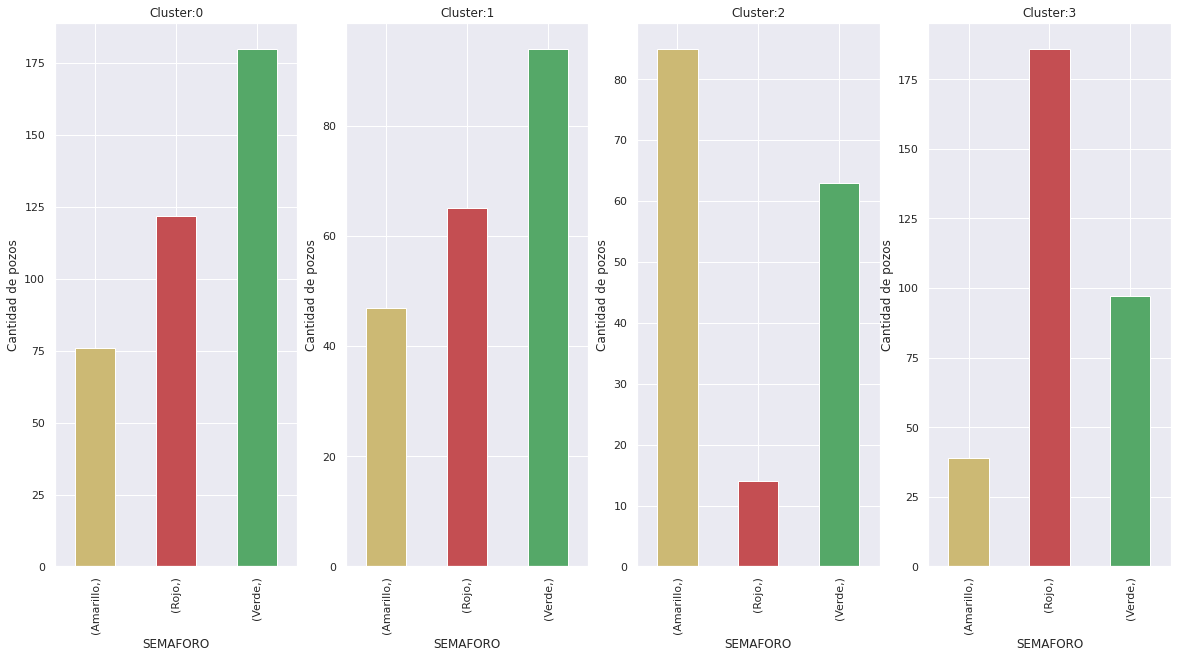

In [34]:
sns.set(rc={'figure.figsize':(20,10)})
n=0

fig, axes = plt.subplots(1,len(centros)) 
for i in range (0,len(centros)):
  plt.subplot(1,len(centros),n+1)
  c=y_centros[y_centros['centroide_cat']==i][['SEMAFORO']].value_counts()
  c.sort_index().plot(kind='bar', color=['y','r','g'])
  plt.ylabel("Cantidad de pozos")
  plt.title("Cluster:"+str(i))
  n=n+1

**Comentarios:**

Cada clúster o centroide no muestra una correlación con la calidad del agua ya que en cada clúster se tiene datos de las 3 calidad en unos casos con frecuencia similar en 2 categorías de calidad del agua.

In [35]:
for i in range (0,len(centros)):
  c=y_centros[y_centros['centroide_cat']==i][['SEMAFORO']].value_counts()
  print("Cantidad de pozos en el centro:",i)
  print(c)
  print("-"*50)
  n=n+1

Cantidad de pozos en el centro: 0
SEMAFORO
Verde       180
Rojo        122
Amarillo     76
dtype: int64
--------------------------------------------------
Cantidad de pozos en el centro: 1
SEMAFORO
Verde       94
Rojo        65
Amarillo    47
dtype: int64
--------------------------------------------------
Cantidad de pozos en el centro: 2
SEMAFORO
Amarillo    85
Verde       63
Rojo        14
dtype: int64
--------------------------------------------------
Cantidad de pozos en el centro: 3
SEMAFORO
Rojo        186
Verde        97
Amarillo     39
dtype: int64
--------------------------------------------------


## **Conclusiones:**

* Para la fase 2 del reto las variables numericas estan almacenadas en el data frame "df_num" y las variables numericas transformadas y limpias estan guardadas dentro del data frame "df_num_trans", y la variable de salida esta dentro del data frame y.

* Se observa que la base de datos tiene datos en su mayor parte. Para ello requiere hacer una conversión a datos de tipo flotante. Para ello se hace un reemplazo de datos en el punto3.
Existe una correlación considerable sobre las siguientes variables:

>> DUR_mg/L vs CONDUCT_mS/cm

>> HG_TOT_mg/L vs MN_TOT_mg/L

>> HG_TOT_mg/L vs FE_TOT_mg/L

>> MN_TOT_mg/L vs FE_TOT_mg/L

* Los pozos están distribuidos de manera aleatoria en el territorio nacional. Dato que también se evidencia en la distribución de los centroides. Con el análisis hasta ahora, no existe una característica que determine una relación entre calidad y ubicación.

* Los clusters calculados por K-Means no mostraron una relación con la calidad del agua. 

*Nota:* Se realizo el experimento con 21 clusters y el resultado fue el mismo.

# **Referencias:**

Vinusa. (2016). *Tema 8 - Correlación: teoría y práctica*. CCG-UNAM. http://www.ccg.unam.mx/~vinuesa/

Aprende MAchine Learning.(2018).K-Means en Python paso a paso.https://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/

Patel, S. (2019). K-means Clustering Algorithm: Implementation and Critical Analysis. Scholars’ Press.